In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# you can comment these lines out usually
# if your Jupyter kernel dies after training
# this can help to fix it
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
df = pd.read_csv('coin_Aave.csv')

In [3]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Aave,AAVE,2020-10-05 23:59:59,55.112358,49.787900,52.675035,53.219243,0.000000e+00,8.912813e+07
1,2,Aave,AAVE,2020-10-06 23:59:59,53.402270,40.734578,53.291969,42.401599,5.830915e+05,7.101144e+07
2,3,Aave,AAVE,2020-10-07 23:59:59,42.408314,35.970690,42.399947,40.083976,6.828342e+05,6.713004e+07
3,4,Aave,AAVE,2020-10-08 23:59:59,44.902511,36.696057,39.885262,43.764463,1.658817e+06,2.202651e+08
4,5,Aave,AAVE,2020-10-09 23:59:59,47.569533,43.291776,43.764463,46.817744,8.155377e+05,2.356322e+08


In [4]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,275.000000,275.000000,275.000000,275.000000,275.000000,2.750000e+02,2.750000e+02
mean,138.000000,271.306751,237.736035,254.506688,255.525845,5.023421e+08,3.168639e+09
std,79.529869,173.030432,151.302431,162.067209,161.649917,4.527200e+08,2.066558e+09
min,1.000000,28.433069,25.966155,27.715080,27.715084,0.000000e+00,6.713004e+07
25%,69.500000,85.078206,76.038104,80.557436,81.100120,2.400042e+08,9.736814e+08
50%,138.000000,306.990536,274.746278,292.268571,295.089229,3.693558e+08,3.697227e+09
75%,206.500000,407.518278,361.685763,382.275163,382.579255,6.204643e+08,4.784464e+09
max,275.000000,666.864979,565.749887,629.231665,632.266488,2.838573e+09,8.063210e+09


In [5]:
df = df.drop(["Name", "Symbol"], axis=1)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [7]:
# scale only relevant variables
num_cols = ["Volume", "High"]
df[num_cols] = scaler.fit_transform(df[num_cols])

In [8]:
df = df.drop(["Date", "Close", "Low", "Open", "Marketcap"], axis=1)

In [9]:
df.head()

,SNo,High,Volume
0,1,0.041789,0.000000
1,2,0.039110,0.000205
2,3,0.021890,0.000241
3,4,0.025797,0.000584
4,5,0.029974,0.000287


In [10]:
df = pd.melt(df, id_vars=["SNo"], value_vars=["Volume", "High"],
             var_name="class", value_name="price")

In [11]:
df.head(10)

,SNo,class,price
0,1,Volume,0.000000
1,2,Volume,0.000205
2,3,Volume,0.000241
3,4,Volume,0.000584
4,5,Volume,0.000287
5,6,Volume,0.000379
6,7,Volume,0.000244
7,8,Volume,0.000477
8,9,Volume,0.000488
9,10,Volume,0.001104


In [12]:
df['class'] = df['class'].replace({"High": 0, "Volume": 1})

In [13]:
class_names = np.array(["High", "Volume"])
num_classes = len(class_names)
classes = [0, 1]

In [14]:
df_class_1 = df[df['class'] == 0]
df_class_2 = df[df['class'] == 1]

# combine into a list for easier iteration
# WHEN WE DO THE TIMESTEP SPLIT
splitted_dfs = [df_class_1, df_class_2] 

In [15]:
df_class_1['class'].value_counts()

class
0    275
Name: count, dtype: int64

In [16]:
df_class_2['class'].value_counts()

class
1    275
Name: count, dtype: int64

In [17]:
max_size = 270
time_step_size = 18

# x_total is going to be the signal 
x_total = []
y_total = []

# built x_total and y_total for all categories (2 at this point)
for category in classes:
    # we will start cutting the original signal data
    # starting from index 0
    index_cutoff = 0

    while index_cutoff / max_size < 1:
        timestep = []

        # take a slice of 50 points, starting from cutoff until cutoff + 50
        slice = splitted_dfs[category].iloc[index_cutoff:index_cutoff + time_step_size]

        #normalize the slice
        slice['price'] = (slice['price'] - slice['price'].min()) / (slice['price'].max() - slice['price'].min())

        # take a slice of selected category / signal type
        # and place it in x_total and y_total
        x_total.append(list(slice['price']))
        y_total.append(category)

        # after each slicing operation, increase the cutoff
        # by 50 (step size), otherwise we get an infinite
        index_cutoff += time_step_size

C:\Users\Roman\AppData\Local\Temp\ipykernel_5492\1069560813.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice['price'] = (slice['price'] - slice['price'].min()) / (slice['price'].max() - slice['price'].min())


In [18]:
slice = splitted_dfs[category].iloc[index_cutoff:index_cutoff + time_step_size]


In [19]:
 # we have now 50 signals, 25 for each category
len(x_total)

30

In [20]:
# we also have 50 TARGET VALUES, 25 for each category
len(y_total)

30

In [21]:
y_total[5]

0

In [22]:
len(x_total[0])

18

In [23]:
import random
zipped = list(zip(x_total, y_total))
random.shuffle(zipped)
x_total, y_total = zip(*zipped)

In [24]:
x_total

([0.34931712980917423,
  0.3335464996683357,
  0.31380448142946565,
  0.3764498897038427,
  0.14356256988302057,
  0.05588364344484583,
  0.06684237288844255,
  0.0299088225922691,
  0.01594327237636472,
  0.40498512504658124,
  0.4231185019875944,
  0.5196216624135507,
  1.0,
  0.8586321641314489,
  0.7825251547729976,
  0.5388557395446141,
  0.22802727019586913,
  0.0],
 [0.0,
  0.08506379249874288,
  0.04904102075626442,
  1.0,
  0.9880564448894948,
  0.49526479552006547,
  0.30606573433374246,
  0.2334823635313607,
  0.5796401619305646,
  0.7211335317702245,
  0.9556832846136201,
  0.4837288713311646,
  0.37021248897654063,
  0.22376356169740805,
  0.3546630026552667,
  0.35487992284464304,
  0.21349730472008066,
  0.19603152277927316],
 [0.5990906612306075,
  0.29142505462708884,
  0.6951182808926659,
  1.0,
  0.975731250568618,
  0.34934295169396284,
  0.28237789026138765,
  0.15632338356561376,
  0.0,
  0.6786534518761935,
  0.66007783539268,
  0.4006157824378275,
  0.5603823599

In [25]:
x_total = np.array(x_total)
y_total = np.array(y_total)

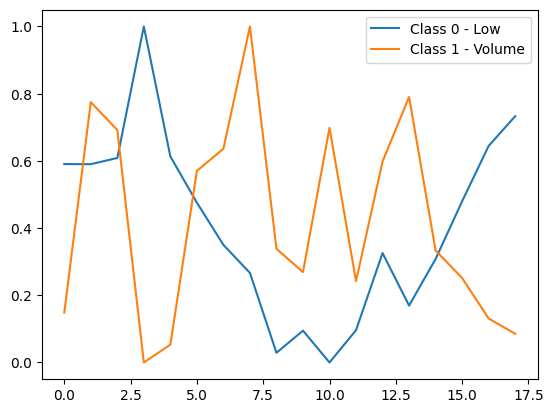

In [26]:
test_signal_index = 2

c_x_train = x_total[y_total == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0 - Low")

c_x_train = x_total[y_total == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1 - Volume")
plt.legend()

In [27]:
#train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size=0.2, random_state=42)

In [28]:
x_train

array([[1.        , 0.96327996, 0.4452648 , 0.94283994, 0.56862475,
        0.25317706, 0.39383722, 0.55850723, 0.61519344, 0.04515401,
        0.0872161 , 0.2452267 , 0.30755666, 0.        , 0.20526521,
        0.19955884, 0.19004221, 0.28410308],
       [0.        , 0.0033249 , 0.06896327, 0.26984302, 0.25693241,
        0.25894857, 0.28441694, 0.32849254, 0.33052019, 0.35990714,
        0.36297116, 0.33306402, 0.32184218, 0.51137421, 0.91907422,
        1.        , 0.92592741, 0.84031127],
       [0.01668902, 0.        , 0.05597537, 0.36850468, 0.62038005,
        0.63770068, 0.56225729, 0.24915474, 0.32918497, 0.57902656,
        0.8103428 , 0.91012702, 1.        , 0.61805955, 0.56623969,
        0.66030837, 0.58518008, 0.39464038],
       [0.34931713, 0.3335465 , 0.31380448, 0.37644989, 0.14356257,
        0.05588364, 0.06684237, 0.02990882, 0.01594327, 0.40498513,
        0.4231185 , 0.51962166, 1.        , 0.85863216, 0.78252515,
        0.53885574, 0.22802727, 0.        ],
    

In [29]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [30]:
def make_model(input_shape):
    model = keras.Sequential(
        [
            keras.layers.Input(input_shape),

            # one convolutional layer package
            keras.layers.Conv1D(filters=24, kernel_size=5, padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.6),
            keras.layers.MaxPooling1D(pool_size=2),
            keras.layers.Conv1D(filters=48, kernel_size=3, padding="same", activation="relu"),
            keras.layers.Dropout(0.7),
            keras.layers.MaxPooling1D(pool_size=2),
            keras.layers.Conv1D(filters=96, kernel_size=3, padding="same", activation="relu"),
            keras.layers.Dropout(0.8),
            keras.layers.Flatten(),

            # our normal neural network after flattening
            keras.layers.Dense(288, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )
    
    return model


model = make_model(input_shape=x_train.shape[1:])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 18, 24)            144       
                                                                 
 batch_normalization (Batch  (None, 18, 24)            96        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 18, 24)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 24)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 48)             3504      
                                                                 
 dropout_1 (Dropout)         (None, 9, 48)             0

In [32]:
epochs = 700
batch_size = 8

# useful callbacks typically for time series
# or CNN in general
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
]

# usual combination
# this example uses sparse categorical crossentropy
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    verbose=1,
)

Epoch 1/700


3/3 [==============================] - 2s 150ms/step - loss: 1.3873 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6879 - val_sparse_categorical_accuracy: 0.8333
Epoch 2/700
3/3 [==============================] - 0s 16ms/step - loss: 1.1000 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6922 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/700
3/3 [==============================] - 0s 17ms/step - loss: 1.7033 - sparse_categorical_accuracy: 0.5000 - val_loss: 0.6960 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/700
3/3 [==============================] - 0s 25ms/step - loss: 1.6409 - sparse_categorical_accuracy: 0.3750 - val_loss: 0.7005 - val_sparse_categorical_accuracy: 0.1667
Epoch 5/700
3/3 [==============================] - 0s 17ms/step - loss: 1.1980 - sparse_categorical_accuracy: 0.5417 - val_loss: 0.7042 - val_sparse_categorical_accuracy: 0.1667
Epoch 6/700
3/3 [==============================] - 0s 17ms/step - loss: 0.9498 - sparse_categorical_accurac

<Axes: >

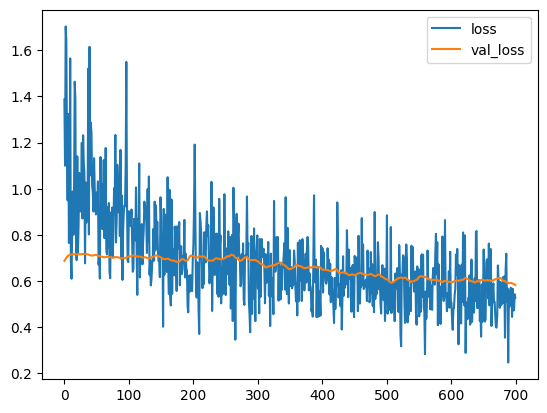

In [33]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

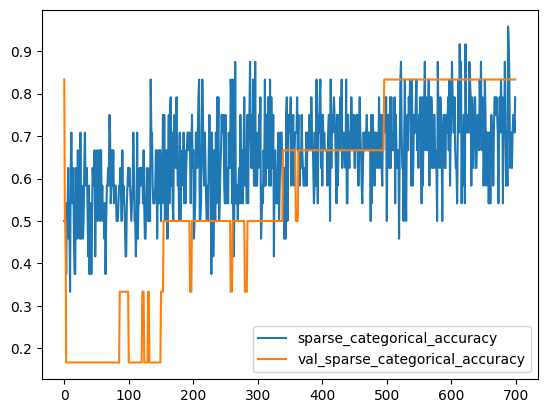

In [34]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [35]:
 # load up the best version of the model
model = keras.models.load_model("best_model.keras")

# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 233ms/step - loss: 0.5826 - sparse_categorical_accuracy: 0.8333
Test accuracy 0.8333333134651184
Test loss 0.5826186537742615


In [36]:
 # make predictions and use argmax
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

1/1 [==============================] - 0s 113ms/step


<Axes: >

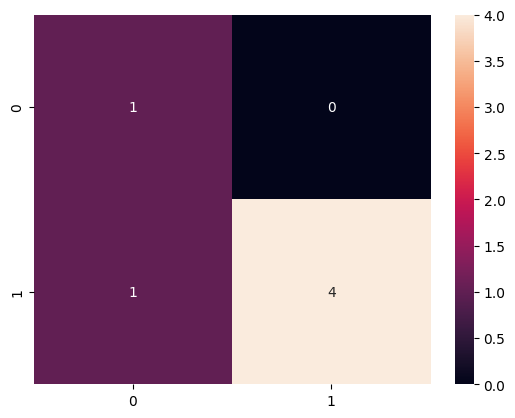

In [37]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [38]:
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.80      0.89         5

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6


Model overall accuracy: 83.33%
